<a href="https://colab.research.google.com/github/anismaysami/Reconstruction-of-DOT-image-using-Deep-Learning/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reconstruction-of-DOT-image-using-Deep-Learning
This program tests various artificial neural networks to reconstruct Diffuse optical tomography Images. Here, we proposed 5 models include:

1.   MLP model as a fully connected neural networks
2.   DOT_conv model as a convolutional NN
3.   Single_layer model as a single fully connected layer (to observe the effect of NN in reconstructing of DOT images
4.   Dense_conv model  a combination model of Dense and Convolutional layers
5.   cnn2 model as another convolution architecture

The performance of networks was evaluated by 4 metrics including mean absolute error (MAE), mean squared error (MSE), Peak Signal to Noise Ratio (PSNR), and Structural Similarity Index Metric (SSIM). For comparison with model-based DOT reconstruction methods, we used the Conjugate gradient algorithm with Total variation (TV) regularization. Fig.1 shows ground truth and reconstructed distribution of absorption coefficient in z=25. Result shows, by using fully connected layer and convolutional neural network, MAE 76% and 69% and MSE 84% and 62% respectively were reduced and PSNR was doubled in comparison with CG. Accordingly, both neural networks have better performance in DOT image reconstruction than model-based method.



#Importing needed packages

In [1]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/superscript.py /content
!cp /content/drive/MyDrive/metrics.py /content
!cp /content/drive/MyDrive/DLModels.py /content
!cp /content/drive/MyDrive/show_reconstructed.py /content
!cp /content/drive/MyDrive/result_metrics.py /content


In [3]:
#importing packages needed
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
#from evaluate_metrics import PSNR, SSIM
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from superscript import get_super


In [4]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr*math.exp(-0.1)
   #if epoch <30:
      #return 0.0005


In [5]:
LS=tf.keras.callbacks.LearningRateScheduler(scheduler)

#Importing data

In [12]:
#importing data
hf_data=h5py.File('/content/drive/MyDrive/data_f.h5', 'r')
data = hf_data['data'][...]
hf_data.close()
hf_mua=h5py.File('/content/drive/MyDrive/mua_f.h5', 'r')
mua = hf_mua['mua'][...]
hf_mua.close()

In [13]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)


In [14]:
#splitting dataset into train,val and test for NOT proccessed dataset
seed=7
np.random.seed(seed)
data_train, data_test, mua_train, mua_test = train_test_split(data, mua, test_size=0.1, random_state=seed)
data_train, data_val, mua_train, mua_val = train_test_split(data_train, mua_train, test_size=0.05, random_state=seed)

data_train=data_train.astype('float32'); data_test=data_test.astype('float32'); data_val=data_val.astype('float32')
mua_train=mua_train.astype('float32'); mua_test=mua_test.astype('float32'); mua_val=mua_val.astype('float32')

In [15]:
print('number of train data is:',len(data_train))
print('number of test data is:',len(data_test))
print('number of validation data is:',len(data_val))

number of train data is: 18168
number of test data is: 2125
number of validation data is: 957


In [16]:
def scaled_data(data_train, data_test, data_val, scaler):
  data_train=data_train.reshape(data_train.shape[0], data_train.shape[1])
  data_test=data_test.reshape(data_test.shape[0], data_test.shape[1])
  data_val=data_val.reshape(data_val.shape[0], data_val.shape[1])

  scaled_data_train=scaler.fit_transform(data_train)
  scaled_data_test=scaler.transform(data_test)
  scaled_data_val=scaler.transform(data_val)

  # inverse transform
  inverse_data_train = scaler.inverse_transform(scaled_data_train)
  inverse_data_test = scaler.inverse_transform(scaled_data_test)
  inverse_data_val = scaler.inverse_transform(scaled_data_val)
  return scaled_data_train, scaled_data_test, scaled_data_val, inverse_data_train, inverse_data_test, scaled_data_val

In [17]:
#normalize data and test
norm_data_scaler=MinMaxScaler(feature_range=(0,1))
norm_data_train, norm_data_test, norm_data_val, inverse_ndata_train, inverse_ndata_test, inverse_ndata_val = scaled_data(data_train, data_test, data_val, norm_data_scaler)

#standardize data train and test
standard_data_scaler=StandardScaler()
standard_data_train, standard_data_test, standard_data_val, inverse_sdata_train, inverse_sdata_test, inverse_sdata_val = scaled_data(data_train, data_test, data_val, standard_data_scaler)

#normalize mua train and test
norm_mua_scaler=MinMaxScaler(feature_range=(0,1))
norm_mua_train, norm_mua_test, norm_mua_val, inverse_nmua_train, inverse_nmua_test, inverse_nmua_val = scaled_data(mua_train, mua_test, mua_val, norm_mua_scaler)

#standardize mua train and test
standard_mua_scaler=StandardScaler()
standard_mua_train, standard_mua_test, standard_mua_val, inverse_smua_train, inverse_smua_test, inverse_smua_val = scaled_data(mua_train, mua_test, mua_val, standard_mua_scaler)

In [18]:
#standardizing norm data
standard_ndata_scaler=StandardScaler()
standard_ndata_train, standard_ndata_test, standard_ndata_val, inverse_sndata_train, inverse_sndata_test, inverse_sndata_val = scaled_data(norm_data_train, norm_data_test, norm_data_val, standard_ndata_scaler)

In [19]:
EL=EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=5, mode='auto')

#Importing models and Evaluate matrics

In [20]:
from DLModels import MLP_model, DOT_convnet, Single_layer, dense_conv, cnn_2
from metrics import MAE, MSE, PSNR, SSIM

#Train, Test, Evaluation dataset for prepared model

In [21]:
#Normalize data (input) train, test, val for mlp_model, single_layer, Dense_conv
norm_data_train=norm_data_train.reshape(len(norm_data_train), 625, 1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 625, 1)
norm_data_val=norm_data_val.reshape(len(norm_data_val), 625, 1)

#Normalize data (input) train, test, val for DOT_convnet and cnn2
norm_data_train_conv=norm_data_train.reshape(len(norm_data_train), 25, 25, 1)
norm_data_test_conv=norm_data_test.reshape(len(norm_data_test), 25, 25, 1)

#Normalize mua (label) train, test, val for mlp_model, DOT_convnet, Single_layer, cnn2
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096, 1)
mua_val=mua_val.reshape(len(mua_val), 4096, 1)

#MLP_model (FCNN)

**Fitting MLP_model**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               160256    
                                                                 
 gaussian_noise (GaussianNoi  (None, 256)              0         
 se)                                                             
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 625)               160625    
                                                                 
 dense_3 (Dense)             (None, 625)               391250    
                                                                 
 dense_4 (Dense)             (None, 625)               391250    
                                                        

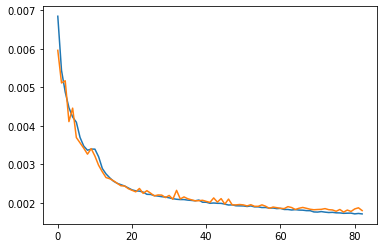

Text(0.5, 1.0, 'learning curve of MLP_model')

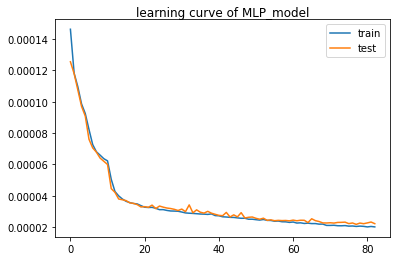

In [ ]:
model_1=MLP_model()
history=model_1.fit(norm_data_train, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_val, mua_val), callbacks=[EL])#,LS])
#round(model.optimizer.lr.numpy(), 5)
test_loss=model_1.evaluate(norm_data_test, mua_test, steps=10)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve of MLP_model', pad=-50)

**Predict by MLP_model**

67/67 [==============================] - 1s 19ms/step


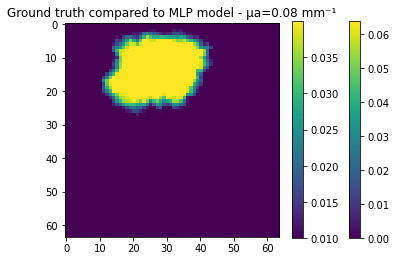

In [ ]:
mua_MLP_hat=model_1.predict(norm_data_test) # mua_MLP_hat is predicted mua by MLP_model
index=105

#display predicted by MLP_model

plt.imshow(mua_MLP_hat[105].reshape(64,64))
plt.title('Prediction by MLP_model')
plt.colorbar()

#displays ground truth
plt.imshow(mua_test[index].reshape(64,64))
plt.title('Ground truth compared to MLP model - \u03BCa=0.08 mm{}'.format(get_super("-1")))
plt.colorbar()

**Evaluate MLP_model**

In [ ]:
index=100
y_test=mua_test[index].reshape(64,64) # y_test is mua_test
y_mlp_pred=mua_MLP_hat[index].reshape(64,64) #y_mlp_pred is predicted mua by mlp
mae_mlp=MAE(y_test, y_mlp_pred)
mse_mlp=MSE(y_test, y_mlp_pred)
psnr_mlp=PSNR(y_test, y_mlp_pred)
print('Mean Absolute Error:', mae_mlp)
print('Mean Squared Error:', mse_mlp)
print('Peak Signal to Noise Ratio:', psnr_mlp)

Mean Absolute Error: 0.0005705206422135234
Mean Squared Error: 9.080138170247665e-07
Peak Signal to Noise Ratio: 23.94090041572324


**Saving MLP_model as mlp_model.h5**

In [ ]:
##save model_1 (model_1 is fcnn)
model_1.save('/content/drive/MyDrive/mlp_model.h5')

#DOT_convnet (Convolutional neural  network)

**Fitting DOT_convnet model**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

Text(0.5, 1.0, 'learning curve of DOT_convnet model')

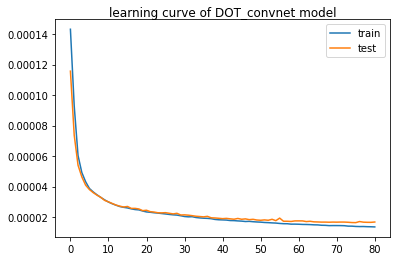

In [ ]:
model_2=DOT_convnet()
history=model_2.fit(norm_data_train_conv, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_test_conv, mua_test), callbacks=[EL])
test_loss=model_2.evaluate(norm_data_test_conv, mua_test, steps=10)
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve of DOT_convnet model', pad=-50)

**Predict by DOT_convnet model**

67/67 [==============================] - 2s 32ms/step


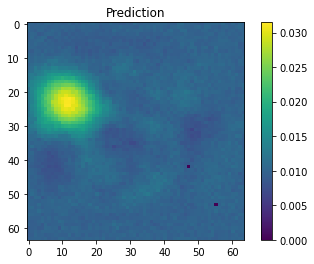

In [ ]:
mua_DOT_convnet_hat=model_2.predict(norm_data_test_conv) # mua_DOT_convnet_hat is predicted mua by DOT_convnet_model
index=16

#display predicted by DOT_convnet model
plt.imshow(mua_DOT_convnet_hat[index].reshape(64,64))
plt.title('Prediction')
plt.colorbar()

#displays ground truth
#plt.imshow(mua_test[index].reshape(64,64))
#plt.title('Ground truth - \u03BCa=0.08 mm{}'.format(get_super('-1')))
#plt.colorbar()

**Evaluate DOT_convnet model**

In [ ]:
index=100
y_test=mua_test[index].reshape(64,64) # y_test is mua_test
y_dot_convnet_pred=mua_DOT_convnet_hat[index].reshape(64,64) # y_dot_convnet_pred is predicted mua by dot_convnet model
mae_dot_convnet=MAE(y_test, y_dot_convnet_pred)
mse_dot_convnet=MSE(y_test, y_dot_convnet_pred)
psnr_dot_convnet=PSNR(y_test, y_dot_convnet_pred)
print('Mean Absolute Error:', mae_dot_convnet)
print('Mean Squared Error:', mse_dot_convnet)
print('Peak Signal to Noise Ratio:', psnr_dot_convnet)

Mean Absolute Error: 0.0006274823099374771
Mean Squared Error: 8.962550168689631e-07
Peak Signal to Noise Ratio: 23.99750899011368


**Saving DOT_convnet as DOT_convnet_model.h5**

In [ ]:
#save model_2 (model_2 is DOT_convnet)
model_2.save('/content/drive/MyDrive/DOT_convnet_model.h5')

#Single_layer (Fully connected layer)

**Fitting Single_layer model**

In [ ]:
model_3=Single_layer()
history=model_3.fit(norm_data_train, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_val, mua_val), callbacks=[EL])#,LS])
#round(model.optimizer.lr.numpy(), 5)
test_loss=model_3.evaluate(norm_data_test, mua_test, steps=10)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve of single layer model', pad=-50)

**Predict by Single_layer model**

In [ ]:
mua_single_layer_hat=model.predict(norm_data_test) # mua_single_layer_hat is predicted mua by single_layer model
index=0

#display predicted by single layer model
plt.imshow(mua_single_layer_hat[index].reshape(64,64))
plt.title('Prediction by single layer model')
plt.colorbar()

#displays ground truth
plt.imshow(mua_test[index].reshape(64,64))
plt.title('Ground truth compared to single_layer model - \u03BCa=0.08 mm{}'.format(get_super("-1")))
plt.colorbar()

**Evaluate Single_layer model**

In [ ]:
index=255
y_test=mua_test[index].reshape(64,64) #y_test is mua_test
y_single_layer_pred=mua_single_layer_hat[index].reshape(64,64) # y_single_layer_pred is predicted mua by single_layer
mae_single_layer=MAE(y_test, y_single_layer_pred)
mse_single_layer=MSE(y_test, y_single_layer_pred)
psnr_single_layer=PSNR(y_test, y_single_layer_pred)
print('Mean Absolute Error:', mae_single_layer)
print('Mean Squared Error:', mse_single_layer)
print('Peak Signal to Noise Ratio:', psnr_single_layer)

**Saving Single_layer model as Single_layer_model.h5**

In [ ]:
model_3.save('/content/drive/MyDrive/Single_layer_model.h5')

#Dense_conv model

**Fitting Dense_conv model**

In [ ]:
model_4=dense_conv()
history=model_4.fit(norm_data_train, mua_train, epochs=500, batch_size=128, validation_data=(norm_data_val, mua_val), callbacks=[EL])#,LS])
#round(model.optimizer.lr.numpy(), 5)
test_loss=model_4.evaluate(norm_data_test, mua_test, steps=10)

#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve of Dense_conv', pad=-50)

**Predict by Dense_conv model**

In [ ]:
mua_Dense_conv_hat=model_4.predict(norm_data_test) # mua_Dense_conv_hat is predicted mua by Dense_conv model
index=9

#display predicted by dense model
plt.imshow(mua_Dense_conv_hat[index].reshape(64,64))
plt.title('Prediction by Dense_conv model')
plt.colorbar()

#displays ground truth
plt.imshow(mua_test[index].reshape(64,64))
plt.title('Ground truth compared to Dense_conv model - \u03BCa=0.08 mm{}'.format(get_super("-1")))
plt.colorbar()

**Evaluate Dense_conv model**

In [ ]:
index=255
y_test=mua_test[index].reshape(64,64) #y_test is mua_test
y_Dense_conv_pred=mua_Dense_conv_hat[index].reshape(64,64) # y_Dense_conv_pred is  predicted mua by Dense_conv model
mae_Dense_conv=MAE(y_test, y_Dense_conv_pred)
mse_Dense_conv=MSE(y_test, y_Dense_conv_pred)
psnr_Dense_conv=PSNR(y_test, y_Dense_conv_pred)
print('Mean Absolute Error:', mae_Dense_conv)
print('Mean Squared Error:', mse_Dense_conv)
print('Peak Signal to Noise Ratio:', psnr_Dense_conv)

**Saving Dense_conv model as Dense_conv_model.h5**

In [ ]:
model_4.save('/content/drive/MyDrive/Dense_conv_model.h5')

#cnn2 model (Convolutional neural network)

 **Fitting cnn2 model**

In [ ]:
model_5=cnn_2()
history=model_5.fit(norm_data_train_conv, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_test_conv, mua_test),shuffle=True, callbacks=[EL])
test_loss=model_5.evaluate(norm_data_test_conv, mua_test, steps=10)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve of cnn2 model', pad=-50)

**Predict by cnn2 model**

In [ ]:
mua_cnn2_hat=model_4.predict(norm_data_test_conv) # mua_cnn2_hat is predicted mua by cnn2 model
index=9

#display predicted by cnn2 model
plt.imshow(mua_cnn2_hat[index].reshape(64,64))
plt.title('Prediction by cnn2 model')
plt.colorbar()

#displays ground truth
plt.imshow(mua_test[index].reshape(64,64))
plt.title('Ground truth compared to cnn2 model - \u03BCa=0.08 mm{}'.format(geT_super("-1")))
plt.colorbar()

**Evaluate cnn2 model**

In [ ]:
index=255
y_test=mua_test[index].reshape(64,64) #y_test is mua_test
y_cnn2_pred=mua_cnn2_hat[index].reshape(64,64) # y_cnn2_pred is  predicted mua by cnn2 model
mae_cnn2=MAE(y_test, y_cnn2_pred)
mse_cnn2=MSE(y_test, y_cnn2_pred)
psnr_cnn2=PSNR(y_test, y_cnn2_pred)
print('Mean Absolute Error:', mae_cnn2)
print('Mean Squared Error:', mse_cnn2)
print('Peak Signal to Noise Ratio:', psnr_cnn2)

**Saving cnn2 model as cnn2_model.h5**

In [ ]:
model_5.save('/content/drive/MyDrive/cnn2_model.h5')

# Loading models

**Importing needed package**

In [22]:
from keras.models import load_model

**Loading MLP model**

In [23]:
# load MLp_model
MLP_model = load_model('/content/drive/MyDrive/mlp_model.h5')
#summarize model.
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               160256    
                                                                 
 gaussian_noise (GaussianNoi  (None, 256)              0         
 se)                                                             
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 625)               160625    
                                                                 
 dense_3 (Dense)             (None, 625)               391250    
                                                                 
 dense_4 (Dense)             (None, 625)               391250    
                                                        

**Loading DOT_conv model**

In [24]:
# load DOT_conv model
DOT_conv_model = load_model('/content/drive/MyDrive/DOT_convnet_model.h5')
#summarize model.
DOT_conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

**Loading Single layer model**

In [ ]:
# load Single_layer model
model_3 = load_model('/content/drive/MyDrive/Single_layer_model.h5')
#summarize model.
model_3.summary()

**Loading Dense_conv model**

In [ ]:
model_4 = load_model('/content/drive/MyDrive/Dense_conv_model.h5')
#summarize model.
model_4.summary()

**Loading cnn2  model**

In [ ]:
model_5 = load_model('/content/drive/MyDrive/cnn2_model.h5')
#summarize model.
model_5.summary()

#Evaluate loaded model

**Importing needed packages**

In [27]:
import show_reconstructed
from result_metrics import evaluation

**show result od MLP model**

67/67 [==============================] - 1s 17ms/step
0.08126333


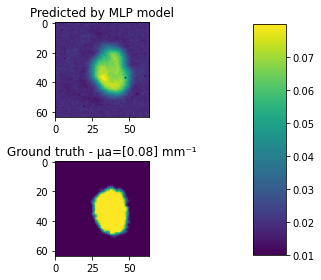

In [32]:
#MLP model
model=MLP_model
model_name='MLP model'
data=norm_data_test
realmua=mua_test
index=896
show_reconstructed.reconstruction(model, model_name, index, data, realmua, 64 , 64 )



**Show result of DOT_conv model**

67/67 [==============================] - 2s 31ms/step
0.087955296


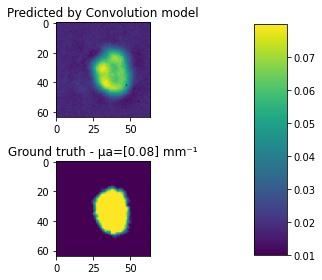

In [33]:
#DOT_conv model
model=DOT_conv_model
model_name='Convolution model'
data=norm_data_test_conv
realmua=mua_test
index=896
show_reconstructed.reconstruction(model, model_name, index, data, realmua, 64 , 64 )

**Show evaluation metrics**

In [29]:
#MLP model
index=258
data=norm_data_test
realmua=mua_test
evaluation(MLP_model, index, data, realmua)

67/67 [==============================] - 1s 19ms/step
Mean Absolute Error: 0.0008406126871705055
Mean Squared Error: 3.8334524106176104e-06
Peak Signal to Noise Ratio: 26.20529887049862
